# 2. More on training
This notebooks covers more details on tweaking and optimizing the training process

In [1]:
import os, warnings
import tensorflow as tf

import matplotlib.pyplot as plt

from glob import glob
from pinn.datasets.qm9 import load_QM9_dataset
from pinn.networks import pinn_network
from pinn.utils import get_atomic_dress
from pinn.models import potential_model

os.environ['CUDA_VISIBLE_DEVICES'] = ''
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

## Optimizing the pipeline
### Caching
Caching stores the decoded dataset in the memory.

In [2]:
# For the purpose of testing, we use only 1000 samples from QM9
filelist = glob('/home/yunqi/datasets/QM9/dsgdb9nsd/*.xyz')[:1000]
dataset = load_QM9_dataset(filelist, split_ratio=1)

In [3]:
d = dataset.repeat().batch(100)
tensors = d.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    for i in range(10):
        sess.run(tensors) # "Warm up" the graph
    %timeit sess.run(tensors)

132 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This speed indicates the IO limit of our current setting.

Now let's cache the dataset to the memory.

In [4]:
d = dataset.cache().repeat().batch(100)
tensors = d.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    for i in range(10):
        sess.run(tensors) # "Warm up" the graph, dataset is cached here
    %timeit sess.run(tensors)

470 µs ± 151 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Preprocessing
You might also see a notable difference in the performance with and without preprocessing, this is especially helpful when you are training with GPUs.

In [5]:
tf.reset_default_graph()

d = dataset.cache().repeat().batch(100)
tensors = d.make_one_shot_iterator().get_next()
output = pinn_network(tensors, pre_level=0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

25.4 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The pinn network provides two levels of preprocessing:

- pre_level = 1 computes the atomic dress and the neighbour list
- pre_level = 2 further computes everything not trainable (the symmetry function and the pi basis)

In [6]:
tf.reset_default_graph()

pre_fn = lambda tensors: pinn_network(tensors, pre_level=1, preprocess=True)
d = dataset.cache().repeat().batch(100).map(pre_fn, num_parallel_calls=16)
tensors = d.make_one_shot_iterator().get_next()
output = pinn_network(tensors, pre_level=1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

17.5 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
tf.reset_default_graph()

pre_fn = lambda tensors: pinn_network(tensors, pre_level=2, preprocess=True)
d = dataset.cache().repeat().batch(100).map(pre_fn, num_parallel_calls=16)
tensors = d.make_one_shot_iterator().get_next()
output = pinn_network(tensors, pre_level=2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

16.6 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You can even cache the preprocessed data.

In [8]:
tf.reset_default_graph()

pre_fn = lambda tensors: pinn_network(tensors, pre_level=2, preprocess=True)
d = dataset.batch(100).map(pre_fn).cache().repeat()
tensors = d.make_one_shot_iterator().get_next()
output = pinn_network(tensors, pre_level=2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

15.9 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Atomic dress
As is in many machine learning tasks, scaling and aligning the labels can 
enhance the performance of the models, and avoid numerical instability.

For datasets like QM9, we can assign a atomic energy to each atom according
to their elements to approximate the total energy. This can be done by simple linear optimizing. We provide a simple tool to generate such "atomic dress".

In [9]:
filelist = glob('/home/yunqi/datasets/QM9/dsgdb9nsd/*.xyz')
dataset = lambda: load_QM9_dataset(filelist, split_ratio={'train':8, 'test':2})
dress, error = get_atomic_dress(dataset()['train'],[1,6,7,8,9],max_iter=2000)

Applying the atomic dress convert the QM9 energies to a "normal" distribution.
It also gives us some sense about the relative distribution of energies, and 
how much our neural network improves from the naive guess of atomic dress.

After applying the atomic dress, turns out the distribution of our training set 
is only about 0.05 Hartree, or 30 kcal/mol

{1: -0.6039418437152411,
 6: -38.07358460885415,
 7: -54.75154708631868,
 8: -75.22503739913694,
 9: -99.87073186940984}

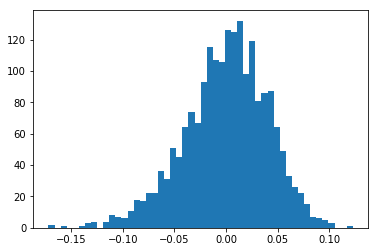

In [10]:
plt.hist(error,50)
dress

## Training with the optimized pipeline

In [11]:
params = {'model_dir': '/tmp/PiNN_QM9_pipeline',
          'network': 'pinn_network',
          'netparam': {
              'pre_level': 2,
              'atom_types':[1, 6, 7, 8, 9],
              'atomic_dress': dress},
          'train': {
              'learning_rate': 1e-3, # Relatively large learning rate
              'en_scale': 627.5 # Here we scale the model to kcal/mol
          }}

# The logging behaviour of estimator can be controlled here
config = tf.estimator.RunConfig(log_step_count_steps=500)

# Preprocessing the datasets
pre_fn = lambda tensors: pinn_network(tensors, preprocess=True, **params['netparam'])
train = lambda: dataset()['train'].cache().repeat().shuffle(1000).batch(100).map(pre_fn, 8)
test = lambda: dataset()['test'].cache().repeat().batch(100).map(pre_fn, 8)

# Running specs
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=1e4)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=100)

In [12]:
model = potential_model(params, config)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/PiNN_QM9_pipeline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7d243035f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. T

({'ENG_MAE': 4.3361235,
  'ENG_RMSE': 6.5197783,
  'loss': 42.50752,
  'global_step': 10000},
 [])

## Monitoring
It's recommended to monitor the training with Tensorboard instead of the stdout here.  
Try `tensorboard --logdir /tmp`, and you can probably see this.

![](tensorboard.png)


## Parallelization with tf.Estimator

The estimator api makes it extremely easy to train on multiple GPUs.

In [ ]:
# suppose you have two cards
distribution = tf.contrib.distribute.MirroredStrategy(num_gpus=2)
config = tf.estimator.RunConfig(train_distribute=distribution)
model = potential_model(params, config)

## Conclusions

Congratulations! You can now train atomic neural networks with 
state-of-art accuracy and speed.


But there's more. With PiNN, the components of ANNs are modulized.
Read following notebooks to see how you can build you own ANN. 